In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import safetensors
from safetensors import safe_open
import torch
from pathlib import Path
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Baseline

In [4]:
feature_path = "/data/lux70/data/pfam/features/all.pt"
with safe_open(feature_path, "pt") as f:
    features = f.get_tensor('features')

print(features.shape)

NUM_TO_EVAL = 512
idxs = np.arange(NUM_TO_EVAL * 2)
np.random.shuffle(idxs)

idxs1 = idxs[:NUM_TO_EVAL]
idxs2 = idxs[NUM_TO_EVAL:]

gt_x1 = features[idxs1].numpy()
gt_x2 = features[idxs2].numpy()

torch.Size([11886, 32])


In [5]:
from plaid.evaluation import parmar_kid, parmar_fid, ConditionalFID

In [6]:
uncond_gt_fid = parmar_fid(gt_x1, gt_x2)
print(uncond_gt_fid)

0.004427324210236727


In [7]:
parmar_kid(gt_x1, gt_x2)

-3.0023683074134057e-05

### Unconditional to Random

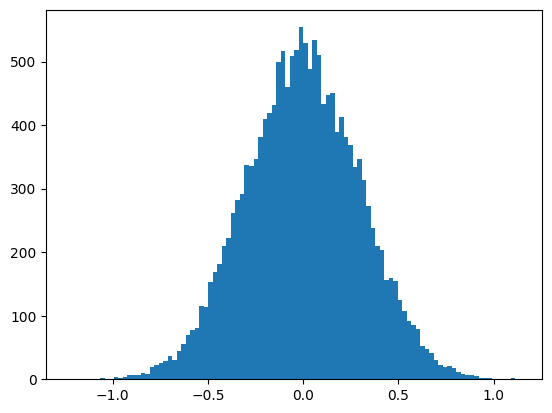

In [8]:
# from scipy.stats import beta

# # Beta distribution parameters can be tweaked for a Gaussian-like shape
# alpha, beta_param = 8, 8
# samples = beta(alpha, beta_param).rvs(1000)

# # Rescale to [-1, 1]
# bounded_samples = 2 * samples - 0.9
# print(bounded_samples.shape)
# _ = plt.hist(bounded_samples.flatten(),bins=100)


random = np.random.normal(0, 0.3, (512, 32))
_ = plt.hist(random.flatten(), bins=100)

In [9]:
random_fid = parmar_fid(random, gt_x1)
print(random_fid)

3.64562124110458


In [10]:
parmar_fid(random, gt_x2)

3.6613143722900707

# Unconditional generation performance

In [11]:
with np.load("/data/lux70/plaid/artifacts/samples/5j007z42/f2219_o3617/240907_0658/latent.npz", allow_pickle=True) as f:
    uncond_gen = f['samples']

print(uncond_gen.shape)
uncond_gen = uncond_gen.astype(np.float32)

(1024, 128, 32)


In [12]:
idxs = np.arange(len(uncond_gen))
np.random.shuffle(idxs)
uncond_gen = uncond_gen[idxs[:NUM_TO_EVAL]]
uncond_gen = uncond_gen.mean(axis=1)
print(uncond_gen.shape)

(512, 32)


In [13]:
uncond_gen_fid = parmar_fid(gt_x1, uncond_gen)
print(uncond_gen_fid)

# just to double check, use the other chunk too
print(parmar_fid(gt_x2, uncond_gen))

0.07637256839755446
0.08355992729511436


In [14]:
print(parmar_kid(gt_x1, uncond_gen))
print(parmar_kid(gt_x2, uncond_gen))

0.002485317666003457
0.002933099899739986


# Amass Conditional FID

In [22]:
from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32
cheap_pipeline = CHEAP_pfam_shorten_2_dim_32()

/homefs/home/lux70/code/cheap-proteins/src/cheap/pretrained.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_fpath)


Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.
Creating ESMFold embedding only model...
ESMFold embedding only model created in 40.42 seconds


In [23]:
from plaid.evaluation import ConditionalFID
from pathlib import Path
import glob
import numpy as np
import torch
import os

samples_dir = Path("/data/lux70/plaid/artifacts/samples/dpm2m/5j007z42")

In [24]:
def cond_code_to_idx(cond_code: str):
    vals = cond_code.split("_")
    return int(vals[0][1:]), int(vals[1][1:])


condgen_to_true = {}
uncond_to_true = {}

batch_size = 128


for i, cond_code in enumerate(os.listdir(samples_dir)):
    function_idx, organism_idx = cond_code_to_idx(cond_code)
    # timestamps = glob.glob(str(samples_dir / cond_code / "*.npz"))
    timestamps = os.listdir(samples_dir / cond_code)
    
    if len(timestamps) > 0:
        try:
            timestamp = timestamps[-1]
            fpath = samples_dir / cond_code / timestamp / "latent.npz"
            print(fpath)
    
            cond_fid = ConditionalFID(
                function_idx=function_idx,
                organism_idx=organism_idx,
                cheap_pipeline=cheap_pipeline,
                batch_size=batch_size,
                max_seq_len=256,
                max_eval_samples=512
            )
            
            with np.load(fpath, allow_pickle=True) as f:
                x = f['samples'].astype(np.float32)
    
            feat = x[:, -1, :, :] # take last timestep only
            feat = feat.mean(axis=1)
            res = cond_fid.run(feat)
            print(cond_code, "Generated <-> GT FID:", res)
    
            condgen_to_true[cond_code] = res
    
            # also try what happens if you do ground truth unconditional to conditional
            res = parmar_fid(feat, gt_x1)
            uncond_to_true[cond_code] = res
            print(cond_code, "Random Real <-> GT FID:", res)
        except Exception as e:
            print(e)
            continue
            
    else:
        pass

/data/lux70/plaid/artifacts/samples/dpm2m/5j007z42/f800_o3617/240915_1016/latent.npz
Found 6115 samples for this condition.
f800_o3617 Generated <-> GT FID: 9.578168442450167
f800_o3617 Random Real <-> GT FID: 8.91863332207055
/data/lux70/plaid/artifacts/samples/dpm2m/5j007z42/f1241_o3617/240915_1417/latent.npz
Found 2023 samples for this condition.
f1241_o3617 Generated <-> GT FID: 8.437451532463982
f1241_o3617 Random Real <-> GT FID: 8.33374188295332
/data/lux70/plaid/artifacts/samples/dpm2m/5j007z42/f2014_o3617/240915_1149/latent.npz
Found 69 samples for this condition.
Need at least 512 samples, as configured.
/data/lux70/plaid/artifacts/samples/dpm2m/5j007z42/f269_o3617/240915_1301/latent.npz
f269_o3617 Generated <-> GT FID: 8.727669894620231
f269_o3617 Random Real <-> GT FID: 8.955344331967886
/data/lux70/plaid/artifacts/samples/dpm2m/5j007z42/f90_o3617/240915_1021/latent.npz
Found 29206 samples for this condition.
f90_o3617 Generated <-> GT FID: 8.943222076144261
f90_o3617 Rando

KeyboardInterrupt: 

# Plot

In [25]:
# turn into dataframe
df1 = pd.DataFrame(list(condgen_to_true.items()), columns=['Key', 'condgen_to_true'])
df2 = pd.DataFrame(list(uncond_to_true.items()), columns=['Key', 'uncond_to_true'])
combined_df = pd.merge(df1, df2, on='Key')
combined_df["GO_idx"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[0])
combined_df["organism_index"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[1])

# attach GO metadata
go_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
combined_df = combined_df.merge(go_df)
combined_df = combined_df.sort_values(by="count")
combined_df['delta'] = combined_df.condgen_to_true - combined_df.uncond_to_true

In [26]:
from matplotlib import cm
from matplotlib.colors import Normalize

values = combined_df['delta']
norm = Normalize(vmin=min(values), vmax=max(values))

colormap = cm.viridis  # You can replace 'viridis' with any other matplotlib colormap
colors = colormap(norm(values))


In [27]:
combined_df

,Key,condgen_to_true,uncond_to_true,GO_idx,organism_index,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,delta
0,f800_o3617,9.578168,8.918633,800,3617,11,"2-C-methyl-D-erythritol 2,4-cyclodiphosphate s...",PF02542,GO:0008685,function,1,0.659535
3,f90_o3617,8.943222,8.620122,90,3617,326,UDP-glycosyltransferase activity,PF00201,GO:0008194,function,1,0.323100
10,f1965_o3617,8.173352,8.924180,1965,3617,311,TRAPPII protein complex,PF12735,GO:1990071,component,1,-0.750829
9,f1028_o3617,7.327812,8.274168,1028,3617,1868,"retromer, cargo-selective complex",PF03635,GO:0030906,component,1,-0.946356
12,f1300_o3617,8.291098,8.895483,1300,3617,2151,urea metabolic process,PF05194,GO:0019627,process,1,-0.604385
14,f1969_o3617,8.788446,8.882111,1969,3617,676,cullin family protein binding,PF12861,GO:0097602,function,1,-0.093665
23,f816_o3617,8.855428,8.587566,816,3617,1739,queuosine salvage,PF02592,GO:1990397,process,1,0.267862
19,f1788_o3617,8.696876,8.364468,1788,3617,1824,regulation of sporulation,PF09388,GO:0043937,process,1,0.332407
27,f1657_o3617,8.726916,8.929963,1657,3617,307,TIM23 mitochondrial import inner membrane tran...,PF08294,GO:0005744,component,1,-0.203047
29,f1070_o3617,9.024928,9.167508,1070,3617,1845,response to UV,PF03851,GO:0009411,process,1,-0.142580


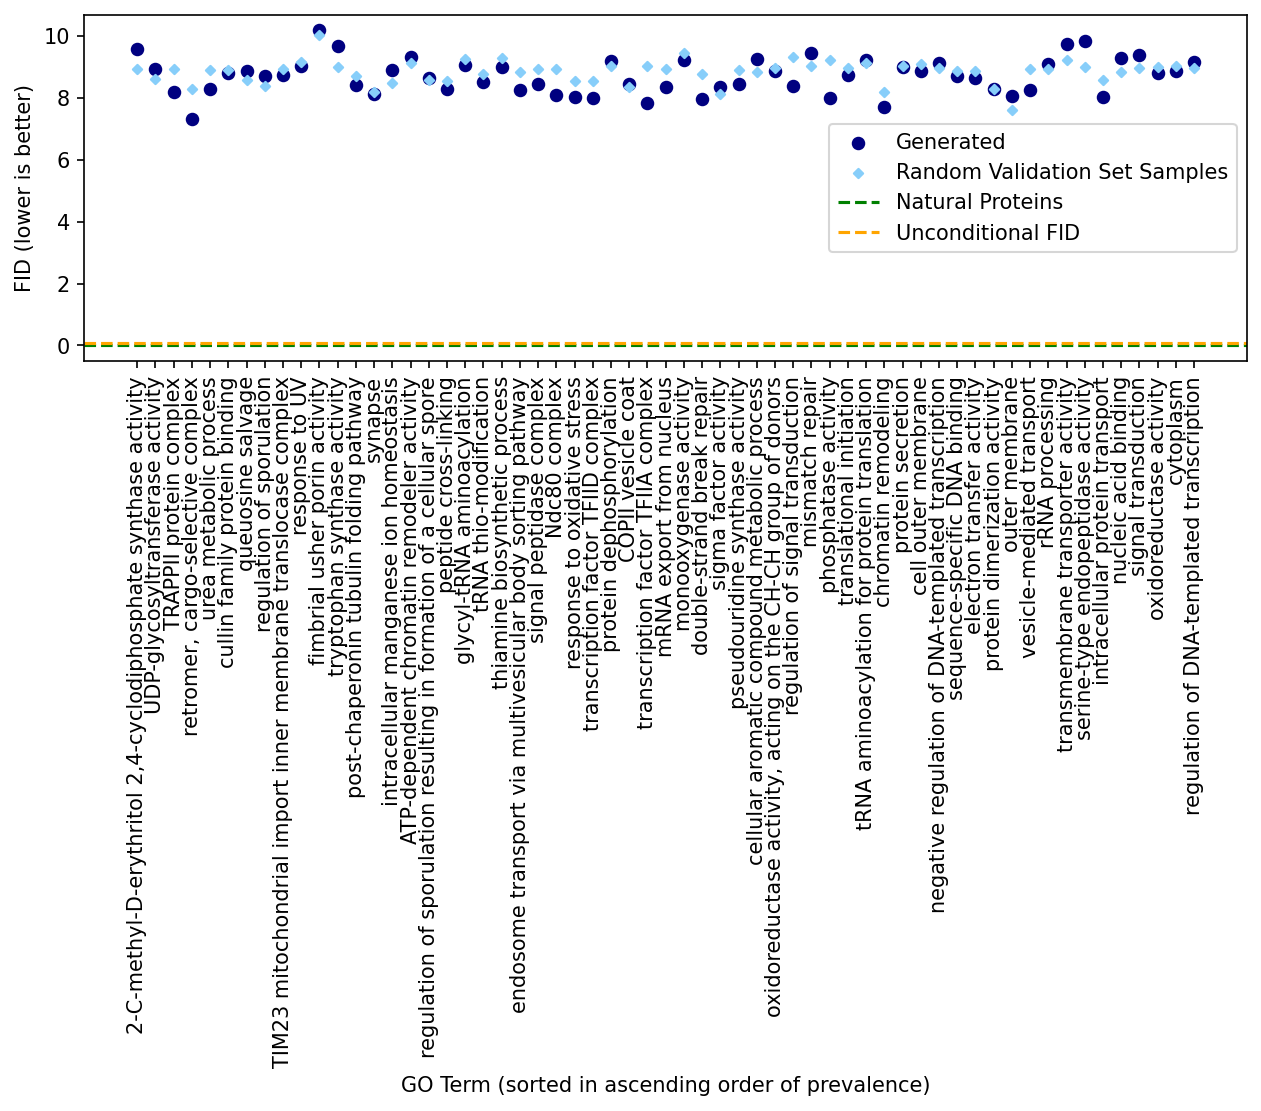

In [30]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(10,3))
ax.scatter(np.arange(len(combined_df)), combined_df['condgen_to_true'].values, label="Generated", s=30, c="navy")
# ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=15, c=colors, marker="D")
ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=10, c="lightskyblue", marker="D")
ax.set_xticks(ticks=np.arange(len(combined_df)), labels=combined_df.GO_term.values, rotation=90)

ax.axhline(y=uncond_gt_fid, color='green', linestyle='--', label="Natural Proteins")
ax.axhline(y=uncond_gen_fid, color='orange', linestyle='--', label="Unconditional FID")


### TODO: modify upper bound on y lim as needed
### TODO: wrap text?

ax.set_xlabel("GO Term (sorted in ascending order of prevalence)")
ax.set_ylabel("FID (lower is better)")

plt.legend()

In [ ]:
combined_df.head()

In [ ]:
combined_df.to_csv("~/cond_fid_tmp.csv", sep=",")

# Across Sampling Timesteps

In [31]:
latent_path = Path("/data/lux70/plaid/artifacts/samples/dpm2m/5j007z42/f800_o3617/240915_1016/latent.npz")

with np.load(latent_path) as f:
    x = f['samples']


In [32]:
x.shape

(512, 11, 76, 32)

In [33]:
gt_x1.shape

(512, 32)

In [34]:
from tqdm.notebook import trange

fids = []

for i in trange(x.shape[1]): # across timesteps
    lat = x[:, i, :, :]
    fid = parmar_fid(gt_x1, lat.mean(axis=1))
    fids.append(fid)

  0%|          | 0/11 [00:00<?, ?it/s]

Text(0, 0.5, 'FID')

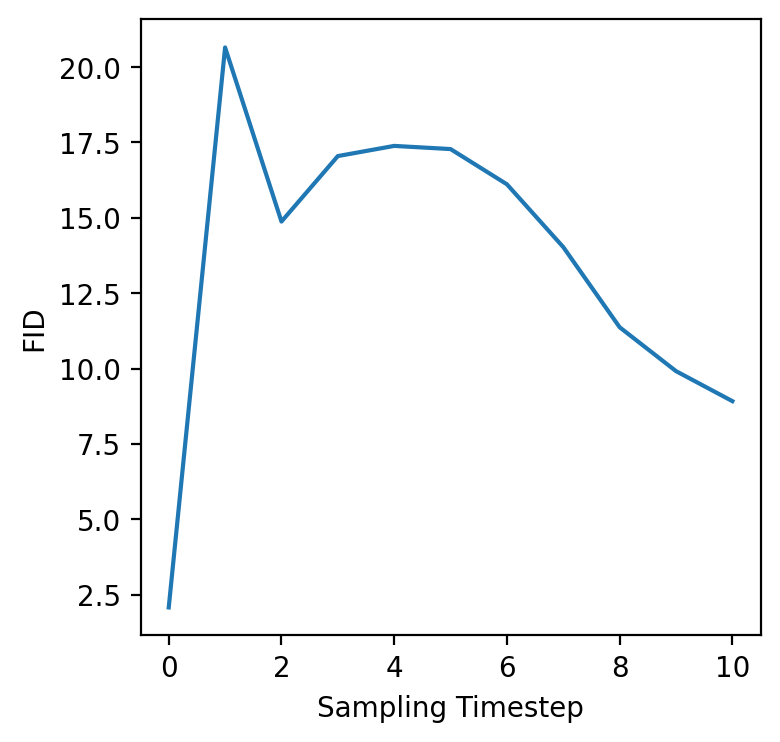

In [35]:
from tqdm.notebook import trange

fids = []

for i in trange(x.shape[1]): # across timesteps
    lat = x[:, i, :, :]
    fid = parmar_fid(gt_x1, lat.mean(axis=1))
    fids.append(fid)

fig,ax = plt.subplots(1,1,dpi=130, figsize=(4,4))
ax.plot(fids)
ax.set_xlabel("Sampling Timestep")
ax.set_ylabel("FID")

In [51]:
import hydra
from omegaconf import OmegaConf
cfg = OmegaConf.load("/homefs/home/lux70/code/plaid/configs/pipeline/dpm_sample_latent.yaml")

In [52]:
cfg

{'model_id': '5j007z42', 'model_ckpt_dir': '/data/lux70/plaid/checkpoints/plaid-compositional', 'organism_idx': 3617, 'function_idx': 2219, 'cond_scale': 10.0, 'num_samples': 1024, 'beta_scheduler_name': None, 'beta_scheduler_start': None, 'beta_scheduler_end': None, 'beta_scheduler_tau': None, 'sampling_timesteps': 50, 'batch_size': -1, 'return_all_timesteps': True, 'output_root_dir': '/data/lux70/plaid/artifacts/samples/dpm2m', 'length': 32, 't_start': None, 't_end': None, 'order': 2, 'skip_type': 'time_uniform', 'method': 'multistep', 'lower_order_final': True, 'denoise_to_zero': False, 'solver_type': 'dpmsolver', 'atol': 0.0078, 'rtol': 0.05}

In [53]:
from plaid.pipeline import DPMSolverSampleLatent

solver = DPMSolverSampleLatent(**cfg)

Sampling timesteps: 50


In [42]:
x = solver.sample()

Starting DPM sampling...
Init the first 1 order values by lower order multistep DPM-Solver.


Order 2 to step 50:   0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Text(0, 0.5, 'FID')

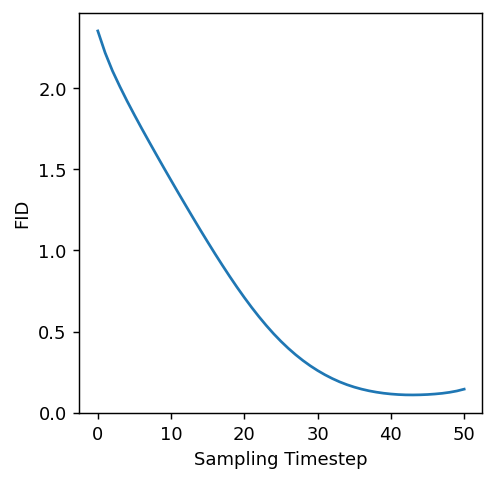

In [45]:
from tqdm.notebook import trange

fids = []
x = x.cpu().numpy()

for i in trange(x.shape[1]): # across timesteps
    lat = x[:, i, :, :]
    fid = parmar_fid(gt_x1, lat.mean(axis=1))
    fids.append(fid)

fig,ax = plt.subplots(1,1,dpi=130, figsize=(4,4))
ax.plot(fids)
ax.set_xlabel("Sampling Timestep")
ax.set_ylabel("FID")

In [46]:
fids[-1]

0.14506118945368052

In [49]:
solver

Starting DPM sampling...


Looping through timesteps for single step solver:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0, 0.5, 'FID')

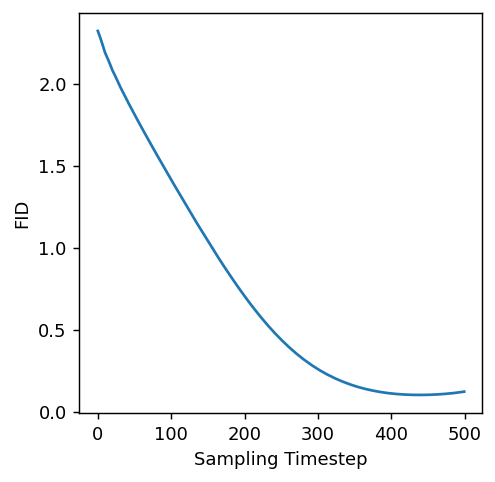

In [60]:
# should be the same as DDIM:

solver.order = 1
solver.method = "singlestep"
solver.sampling_timesteps=500

x_singlestep_1 = solver.sample().cpu().numpy()

from tqdm.notebook import trange

fids = []

for i in trange(x_singlestep_1.shape[1]): # across timesteps
    lat = x_singlestep_1[:, i, :, :]
    fid = parmar_fid(gt_x1, lat.mean(axis=1))
    fids.append(fid)

fig,ax = plt.subplots(1,1,dpi=130, figsize=(4,4))
ax.plot(fids)
ax.set_xlabel("Sampling Timestep")
ax.set_ylabel("FID")

In [61]:
fids[-1]

0.12534767861710944